In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [29]:
import torch

#import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset

In [30]:
METHOD = False
USE_GPU = False
LINUX = True
#Use linux file paths


if USE_GPU:
    #torch.zeros(1).cuda()
    #torch.cuda.is_available()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: cpu


In [31]:
icouk_data_file = '..\\Data\\icouk_sighting_data_with_params.csv'
icop_data_file = '..\\Data\\icop_ahmed_2020_sighting_data_with_params.csv'
alrefay_data_file = '..\\Data\\alrefay_2018_sighting_data_with_params.csv'
allawi_data_file = '..\\Data\\schaefer_odeh_allawi_2022_sighting_data_with_params.csv'
yallop_data_file = '..\\Data\\Data/yallop_sighting_data_with_params.csv'

if LINUX:
    icouk_data_file = '../Data/icouk_sighting_data_with_params.csv'
    icop_data_file = '../Data/icop_ahmed_2020_sighting_data_with_params.csv'
    alrefay_data_file = '../Data/alrefay_2018_sighting_data_with_params.csv'
    allawi_data_file = '../Data/schaefer_odeh_allawi_2022_sighting_data_with_params.csv'
    yallop_data_file = '../Data/yallop_sighting_data_with_params.csv'

icouk_data = pd.read_csv(icouk_data_file)
icop_data = pd.read_csv(icop_data_file)
alrefay_data = pd.read_csv(alrefay_data_file)
allawi_data = pd.read_csv(allawi_data_file)
yallop_data = pd.read_csv(yallop_data_file)


data = pd.concat([icouk_data,icop_data,alrefay_data,yallop_data])

print(f"Loaded {data.shape[0]} rows")

data = data.drop(["Index","q","W","q'","W'",'Visibility', 'Source'], axis = 1)

if METHOD: # method and methods columns, will be changed
    data = data.drop('Seen', axis = 1) # replaced by method column
    ptype = [r"Not_seen", r"Seen_eye", r"Seen_binoculars", r"Seen_telescope", r"Seen_ccd"] # CHANGE THIS
else:
    data = data[data["Method"] !="Seen_binoculars"] #DROP BINOCULARS
    data = data[data["Method"] !="Seen_ccd"] #DROP CCD
    data = data[data["Method"] !="Seen_telescope"] #DROP TELESCOPE
    
    data=data.drop(['Method','Methods'], axis = 1)
    # List of label options
    ptype = [r"Seen", r"Not_seen"]

print(f"Selected {data.shape[0]} rows")

variable_list =  data.columns.tolist()
variable_list.remove('Seen')

data['Sunset'] -= data['Date'] # reducing magnitude of date datapoints
data['Moonset'] -= data['Date']
data['Date'] -= 2400000
data['Date'] *= 1/10000

Loaded 3555 rows
Selected 3101 rows


In [32]:
data.head(10)

,Date,Latitude,Longitude,Moon Age,Sunset,Moonset,Lag,Moon Alt,Moon Az,Sun Alt,Sun Az,Moon-Earth Dist,Sun-Moon Dist,ARCL,ARCV,DAZ,Illumination,Parallax,Cloud Level,Seen
0,5.730922,53.95763,-1.08271,0.724,-0.00656,0.00820,21.25000,1.07310,252.63669,-2.19904,259.67487,0.00271,0.99508,7.76046,3.27214,7.03818,0.00458,54.15168,1.0,Not_seen
1,5.733919,53.95763,-1.08271,1.690,-0.01580,0.01976,51.21667,2.93009,235.97254,-3.80413,244.70058,0.00266,0.98725,11.01981,6.73422,8.72803,0.00922,55.07029,0.5,Not_seen
2,5.739819,53.95763,-1.08271,0.688,-0.01849,0.02312,59.91667,3.36351,234.01106,-4.02231,237.26745,0.00252,0.98095,8.07090,7.38583,3.25639,0.00495,58.06216,0.5,Not_seen
3,5.742824,53.58333,-2.43333,1.740,-0.02731,0.03413,88.48333,5.96340,246.17414,-6.30098,253.74311,0.00244,0.98427,14.40433,12.26438,7.56896,0.01572,59.64383,1.0,Not_seen
4,5.742824,52.63860,-1.13169,1.738,-0.02687,0.03359,87.06667,6.02324,246.74294,-6.34866,254.06088,0.00244,0.98427,14.36689,12.37190,7.31794,0.01564,59.63664,0.0,Seen
5,5.745726,52.63860,-1.13169,0.763,-0.01411,0.01764,45.71667,3.06525,263.04825,-3.90430,268.33129,0.00240,0.99075,8.74353,6.96955,5.28304,0.00581,60.86156,1.0,Not_seen
6,5.745726,51.87967,-0.41748,0.761,-0.01396,0.01746,45.25000,3.09221,263.17229,-3.92596,268.33470,0.00240,0.99075,8.71037,7.01817,5.16242,0.00577,60.85974,0.5,Not_seen
7,5.745726,51.39822,-0.19837,0.761,-0.01389,0.01736,45.00000,3.11294,263.24948,-3.94293,268.34037,0.00240,0.99075,8.69875,7.05586,5.09089,0.00575,60.85847,1.0,Not_seen
8,5.745726,53.95763,-1.08271,0.763,-0.01427,0.01785,46.25000,2.99260,262.82919,-3.84621,268.29021,0.00240,0.99075,8.74957,6.83881,5.46102,0.00582,60.86555,1.0,Not_seen
9,5.748732,53.58333,-2.43333,1.818,-0.02768,0.03460,89.68333,6.24688,278.23448,-6.44510,292.14456,0.00240,0.99931,18.80913,12.69197,13.91008,0.02670,60.83045,1.0,Not_seen


In [33]:
y = np.array(data['Seen'])
X = np.array(data[variable_list])

y[y == 'Seen'] = int(1)
y[y == 'Not_seen'] = int(0)

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, y,test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [34]:
# Define the neural network model
class CustomNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)  # Output layer with 1 neuron for binary classification
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Sigmoid activation for binary classification, now softmax
        return x
    
input_size = len(variable_list)  # Number of input variables
hidden_size = 32  # Number of neurons in the hidden layers #32
output_size = 2 # for binary output
model = CustomNN(input_size, hidden_size, output_size).to(device)

num_epochs = 300
batch_size = 60

# Define binary cross-entropy loss and Adam optimizer
criterion = nn.CrossEntropyLoss() #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay = 0.01) #0.001
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=2, factor=0.9) # i dont know what this is

MY METHOD

In [35]:
X_train_tensor = torch.from_numpy(X_train).float()
Y_train_tensor = torch.from_numpy(Y_train.astype("float64")).float()

X_test_tensor = torch.from_numpy(X_test).float()
Y_test_tensor = torch.from_numpy(Y_test.astype("float64")).float()

In [36]:
# # Paramaters for a loop


# for epoch in range(num_epochs):
#     correct = 0
#     for i in range(0, len(X_train), batch_size):
#         inputs = X_train_tensor[i:i+batch_size]
#         targets = Y_train_tensor[i:i+batch_size]

#         targets = targets.type(torch.LongTensor)  
        
#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
        
        
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#     # Print training loss after each epoch
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

ANNA METHOD

In [37]:
#data prep for anna code
trainset = TensorDataset(X_train_tensor, Y_train_tensor)
testset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [38]:
def train(model, trainloader, optimiser, device):

    train_loss = 0.0

    model.train()
    for batch_idx, (data, labels) in enumerate(trainloader):
        data, labels = data.to(device), labels.to(device)

        optimiser.zero_grad()

        #p_y = F.softmax(model(data), dim=1)
        #loss = model.loss(p_y, labels)
        p_y = model(data)
        loss_criterion = nn.CrossEntropyLoss()
        labels = labels.type(torch.LongTensor) 
        labels = labels.to(device)
        loss = loss_criterion(p_y, labels)
            
        train_loss += loss.item() * data.size(0)

        loss.backward()
        optimiser.step()

    train_loss /= len(trainloader.dataset)
    return train_loss

def test(model, testloader, device):

    correct = 0
    #total = 0
    test_loss = 0.0

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(testloader):
            data, labels = data.to(device), labels.to(device)

            #p_y = F.softmax(model(data), dim=1)
            #loss = model.loss(p_y, labels)
            p_y = model(data)
            loss_criterion = nn.CrossEntropyLoss()
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            loss = loss_criterion(p_y, labels)
                
            test_loss += loss.item() * data.size(0)

            preds = p_y.argmax(dim=1, keepdim=True)
            correct += preds.eq(labels.view_as(preds)).sum().item()

        test_loss /= len(testloader.dataset)
        accuracy = correct / len(testloader.dataset)

    return test_loss, accuracy

In [39]:
# #anna method
result_arr=[]
_bestacc = 0.
quiet = True
result_arr = np.zeros((num_epochs,4))

for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    train_loss = train(model, train_loader, optimizer, device)
    test_loss, accuracy = test(model, test_loader, device)
        
    scheduler.step(test_loss)

    # check early stopping criteria:
    #if early_stopping and accuracy>_bestacc:
    #    _bestacc = accuracy
    #    torch.save(model.state_dict(), modfile)
    #    best_acc = accuracy
    #    best_epoch = epoch
        
    # create output row:
    results = [epoch, train_loss, test_loss, accuracy]
    
    result_arr[epoch] = results
    if not quiet:
        print('Epoch: {}, Validation Loss: {:4f}, Validation Accuracy: {:4f}'.format(epoch, test_loss, accuracy))
        print('Current learning rate is: {}'.format(optimizer.param_groups[0]['lr']))
        
print("Final validation error: ",100.*(1 - accuracy))
#if early_stopping:
#    print("Best validation error: ",100.*(1 - best_acc)," @ epoch: "+str(best_epoch))r    result_arr

Final validation error:  8.58369098712446


In [40]:
#print(result_arr)

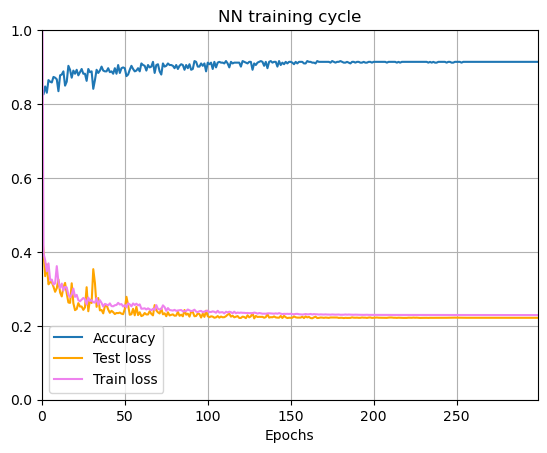

In [41]:
#print(result_arr)
#plt.fig()
plt.plot(result_arr[:,0],result_arr[:,3],linestyle='-', label='Accuracy')
plt.plot(result_arr[:,0],result_arr[:,2],linestyle='-', c='orange',label='Test loss')
plt.plot(result_arr[:,0],result_arr[:,1],linestyle='-', c='violet',label='Train loss')
plt.ylim(0,1)
plt.xlim(0,num_epochs-1)
plt.title('NN training cycle')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.show()

In [42]:
print(r'Final accuracy is {}'.format(result_arr[-1,3]))

Final accuracy is 0.9141630901287554


In [43]:
X_test_tensor = torch.Tensor(X_test).to(device)
predictions = model(X_test_tensor)

In [44]:
#model = Sequential([
#    Dense(32, activation='softmax', input_shape=(18,)),
#    Dense(32, activation='softmax'),
#    Dense(1, activation='sigmoid'), # refelects catagory
#])

#model.compile(optimizer='adam',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])
#
#hist = model.fit(X_train, Y_train,
#          batch_size=32, epochs=100,
#          validation_data=(X_val, Y_val))

In [45]:
#model.evaluate(X_test, Y_test)[1]